In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.special import factorial
import sympy as sp
import scipy as sc
from scipy.optimize import minimize_scalar

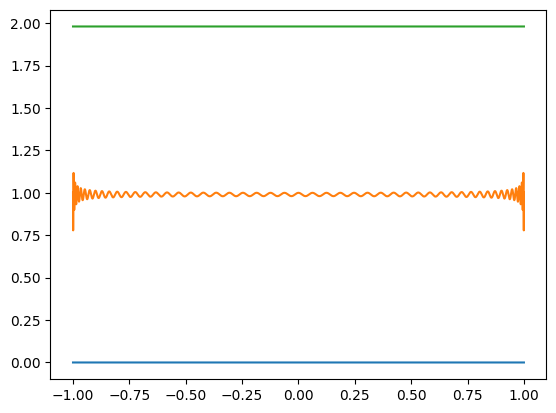

In [82]:
pr = Performative_Regression(k=50, n=1, T=1, sigma=0.1)

thetas = np.linspace(-1, 1, pr.k+1)
def prod(theta):

    p = 1 
    for i in range(pr.k+1):
        p = p * (theta - pr.thetas[i])

    return p

def sum2(theta):

    s = 0 
    for j in range(pr.k+1):
        p = 1 
        for i in range(pr.k+1):
            if i != j:
                p = p * (theta - pr.thetas[i]) / (pr.thetas[j] - pr.thetas[i])
        s = s + p**2
    return s


t = np.linspace(-1, 1, 10000)
plt.plot(t, prod(t))

plt.plot(t, sum2(t))
plt.plot(t, (2 - 1/(pr.k+1) * np.ones(len(t))))
plt.show()

In [72]:
class Performative_Regression:

    def __init__(self, k, n , T, sigma=1, M=1):
        """
        Parameters:
        - k (int): Polynomial degree.
        - n (int): Number of samples for each theta_i.
        - T (float): Total number of rounds, should be > kn.
        - sigma (float, optional): Standard deviation of the noise. Default is 1.
        - M (float, optional): Bound of the derivatives of f. Default is 1.
        """
        self.k = k
        self.n = n
        self.T = T
        self.sigma = sigma
        self.M = M
        self.z = 1.96

        # Produce k+1 Chebyshev nodes
        self.thetas = np.cos(np.pi * (2*np.arange(1, self.k+2) - 1 ) / (2*(self.k + 1)))

        # 
        self.thetas = np.cos(np.pi * (2*np.arange(self.k+1) + 1 ) / (2*self.k + 2)) / np.cos(np.pi / (2*self.k + 2))


        self.f_hat_values = self.f_hat()
               
    def f(self, theta):
        """
        Computes the true function value at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The function value at the specified theta.
        """

        
        fun = theta + theta**2 
        fun = np.sin(4*theta)
        return fun
  
    def f_hat(self):
        """
        Generates the array of noisy function values at the Chebyshev nodes.

        Returns:
        - numpy.ndarray: Array with element i equal to f_hat(theta_i) where theta_i is the ith Chebyshev node.
        """
        
        Y = (
            np.repeat(self.f(self.thetas)[:, np.newaxis], self.n, axis=1) +
            np.random.normal(0, self.sigma, (self.k+1, self.n))
        )

        f_hat = np.mean(Y, axis=1)

        return f_hat

    def vandermonde_matrix(self):
        """
        Computes the Vandermonde matrix with Chebyshev nodes.

        Returns:
        - numpy.ndarray: The Vandermonde matrix.
        """

        return np.vander(self.thetas, increasing=True)

    def vandermonde_determinant(self):
        """
        Computes the determinant of the Vandermonde matrix.

        Returns:
        - float: The determinant of the Vandermonde matrix.
        """

        det = (-1)**((self.k+1) * self.k / 2 ) * ((self.k+1)**(self.k+1) / 2**(self.k*self.k))**(1/2)
        
        return det   
    
    def true_loss(self, theta):
        """
        Computes the true objective function at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The true objective function evaluated at theta.
        """

        return self.f(theta)**2 - 2 * theta * self.f(theta) + theta**2
    
    def g_hat(self, theta):

        """
        Computes the estimated g_hat at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated function value at the specified theta.
        """
        p_theta = 0
        for i in range(self.k+1):
            prod = 1
            for j in range(self.k+1):
                if j != i:
                    prod = prod * (theta - self.thetas[j]) / (self.thetas[i] - self.thetas[j])

            p_theta = p_theta + prod * self.f_hat_values[i]
        
        return p_theta
    
    def bayes_estimate(self):

        V = self.vandermonde_matrix()
        S2 = np.eye(self.k+1) @ np.array([i for i in range(1, self.k+2)])
        S = np.linalg.inv(S2 + V.T @ V / self.sigma)

        mu = 1 / self.sigma * S @ V.T @ self.f_hat_values 

        return mu
    
    def approxim(self, theta):

        vec = np.array([theta**i for i in range(self.k+1)])

        return vec @ self.bayes_estimate()

    def estimated_loss(self, theta):
        """
        Computes the estimated objective function value at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated objective function value at the specified theta.
        """

        g_estimate = self.g_hat(theta)

        return g_estimate**2 - 2 * theta * g_estimate + theta**2

    def optimistic_loss(self, theta):

        ci = self.conf_interval_at_theta(theta)

        g_values = np.linspace(self.g_hat(theta) - ci, self.g_hat(theta) + ci, 1000)

        return np.min(g_values**2 - 2 * theta * g_values + theta**2, axis=0)
    
    def pessimistic_loss(self, theta):

        ci = self.conf_interval_at_theta(theta)

        g_values = np.linspace(self.g_hat(theta) - ci, self.g_hat(theta) + ci, 1000)

        return np.max(g_values**2 - 2 * theta * g_values + theta**2, axis=0)

    def remainder(self, theta):
        """
        Computes the upper bound of the absolute value of the remainder term for a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The upper bound of the absolute value of the remainder term at the specified theta.
        """

        cheb_polynomial = np.cos((self.k+1)*np.arccos(theta))/(2**(self.k))

        return self.M * np.abs(cheb_polynomial) / math.factorial(self.k + 1)

    def lagrange_bound(self, theta):
        """
        Computes the sum of the absolute value of the Lagrange polynomials.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The sum of the absolute value of the Lagrange polynomials.
        """

        sum_new = 0
        for i in range(self.k+1):
            sum_new += np.abs(
                (-1)**i * np.sin(np.pi * (2*i + 1) / (2*self.k + 2)) * np.cos((self.k+1)*np.arccos(theta)) / (self.k+1) / (theta - np.cos(np.pi * (2*i + 1) / (2*self.k + 2)))
            )  

        #return np.sqrt(2 - 1 / (self.k + 1))
        return sum_new
       
    def conf_interval_at_theta(self, theta):

        """
        Computes the confidence interval at a theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The confidence interval at the specified theta.
        """
        B_1 = self.remainder(theta)
        B_2 = self.lagrange_bound(theta) * self.z * self.sigma / np.sqrt(self.n)
        
        return B_1 + B_2

    def bayes_ci(self, theta):
        lagrange_squared_sum = 0

        for i in range(self.k+1):

            lagrange_square = 1
            for j in range(self.k+1):
                if j != i:
                    lagrange_square = lagrange_square * (theta - self.thetas[j]) / (self.thetas[i] - self.thetas[j])

            lagrange_squared_sum += lagrange_square**2

        #return lagrange_squared_sum
        #return self.z * self.sigma * np.sqrt(2 - 1 / (self.k + 1)) / np.sqrt(self.n)
        return self.z * self.sigma * np.sqrt(lagrange_squared_sum) / np.sqrt(self.n)

    def R(self, theta):

        prod = 1 
        for i in range(self.k+1):
            prod = prod * (theta - self.thetas[i])

        #return prod
        #return self.M / 2**self.k / math.factorial(self.k+1)
        return np.abs(prod * self.M / math.factorial(self.k+1))
    
    def minimum(self):

        t = np.linspace(-1, 1, 10000)
        gs = self.estimated_loss(t)
        fs = self.true_loss(t)
        estimated_min = t[np.argmin(gs)]
        true_min = t[np.argmin(fs)]
        return estimated_min, true_min

    def plot_f_vs_g(self):
        
        t = np.linspace(-1, 1, 1000)
        
        plt.plot(t, self.f(t), 'r--', label=r'$f(\theta)$')
        plt.plot(t, self.g_hat(t), 'g--', label=r"$\hat{g}(\theta)$")
        
        #plt.plot(t, self.g_hat(t) - self.R(t) - self.bayes_ci(t), 'k--')
        #plt.plot(t, self.g_hat(t) + self.R(t) + self.bayes_ci(t), 'k--', label="Confidence interval")
        plt.fill_between(t, self.g_hat(t) - self.R(t) - self.bayes_ci(t), self.g_hat(t) + self.R(t) + self.bayes_ci(t), alpha=0.3)
        
    def plot_objectives(self):
        
        t = np.linspace(-1, 1, 1000)
        plt.plot(t, self.true_loss(t), 'C1', label='true objective')
        plt.plot(t, self.estimated_loss(t), 'C1--', label=f'estimated loss for k={self.k}')
        plt.fill_between(t,
                         self.optimistic_loss(t),
                         self.pessimistic_loss(t),
                         alpha=0.3,
                         color='C1')

        estimated_min = self.minimum()[0]
        true_min = self.minimum()[1]
        plt.scatter(true_min, self.true_loss(true_min), label=r'$\theta_{PO}$', color='k')
        plt.scatter(estimated_min, self.true_loss(estimated_min), label=r'$\hat{\theta}_{PO}$', marker='x', color='r')
        plt.xlabel(r"$\theta$")


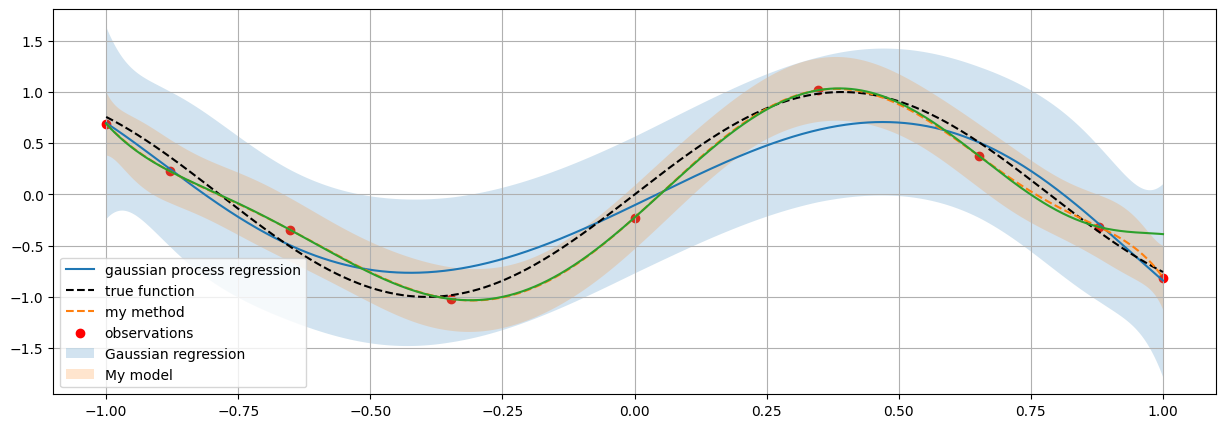

In [81]:
class GaussianRegression:
    def __init__(self, degree, sigma):
        self.degree = degree
        self.sigma = sigma
        self.X_train = None
        self.y_train = None
        self.alpha = None
        self.K_inv = None  # Store the inverse of the kernel matrix

    def polynomial_kernel(self, X1, X2):
        return (np.dot(X1, X2.T) + 1) ** self.degree

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        K = self.polynomial_kernel(X, X)
        K += np.eye(K.shape[0]) * (self.sigma ** 2)
        self.K_inv = np.linalg.inv(K)
        self.alpha = self.K_inv.dot(y)

    def predict(self, X):
        # Compute mean of the prediction
        K_trans = self.polynomial_kernel(X, self.X_train)
        mean = K_trans.dot(self.alpha)

        # Compute variance (confidence intervals)
        # Variance of the prediction is given by K(X, X) - K_trans * K_inv * K_trans.T
        K = self.polynomial_kernel(X, X)
        variance = K - K_trans.dot(self.K_inv).dot(K_trans.T)
        std_dev = np.sqrt(np.diag(variance))

        return mean, std_dev

k=8
pr = Performative_Regression(k=k, n=10, T=1, sigma=0.5, M=4**(k+1))

gr = GaussianRegression(degree=pr.k, sigma=pr.sigma)
gr.fit(pr.thetas.reshape(-1, 1), pr.f_hat_values)



t = np.linspace(-1, 1, 1000).reshape(-1, 1)
t2 = np.linspace(-1, 1, 1000)
y_mean, y_std = gr.predict(t)
plt.figure(figsize=(15, 5))
plt.plot(t, y_mean, label='gaussian process regression')
plt.plot(t, pr.f(t), "k--", label="true function")
plt.plot(t, pr.g_hat(t), '--', label='my method')
plt.scatter(pr.thetas, pr.f_hat_values, color='r', label='observations')
plt.fill_between(t.ravel(), y_mean - 1.96 * y_std - pr.R(t2), y_mean + 1.96 * y_std + pr.R(t2), alpha=0.2, label='Gaussian regression')
plt.fill_between(t.ravel(), pr.g_hat(t2) - pr.R(t2) - pr.bayes_ci(t2), pr.g_hat(t2) + pr.R(t2) + pr.bayes_ci(t2), alpha=0.2, label='My model')
ys = [pr.approxim(i) for i in np.linspace(-1, 1, 1000)]
plt.plot(np.linspace(-1, 1, 1000), ys)
plt.legend()
plt.grid()
plt.show()


In [20]:
pr.bayes_estimate()

array([ -0.78748262,   3.55155795,  12.44021676,  -3.63757325,
       -48.92664147, -10.28579362,  70.47997363,   9.82592696,
       -32.86529084])

In [21]:
class Adaptive_Interpolation:

    def __init__(self, K, M=1, sigma=0.1):
        """
        K - even
        """
        self.sigma = sigma
        self.M = M
        self.K = K

        # Initialize possible nodes (Chebyshev K+1)
        self.all_nodes = np.cos(np.pi * (2*np.arange(1, self.K+2) - 1 ) / (2*(self.K + 1)))

        self.used_nodes = {node : 0 for node in self.all_nodes}

        self.f_estimates = {self.all_nodes[(self.K + 1) // 2] : self.observation(self.all_nodes[(self.K + 1) // 2])}

    def f(self, theta):

        fun = np.cos(theta) - np.sin(theta)
        
        return fun
    
    def observation(self, node):

        return np.random.normal(self.f(node), self.sigma)

    def g_estimate(self, theta, nodes, estimates_at_nodes):

        sum = 0
    
        for i in range(len(nodes)):
            
            l_i = 1
            for j in range(len(nodes)):
                if j != i:
                    l_i = l_i * (theta - nodes[j]) / (nodes[i] - nodes[j])

            sum += estimates_at_nodes[i] * l_i

        return sum

    def lower_bound(self, theta, nodes, estimates_at_nodes):
        
        1 + 1


    def step(self):

        new_node = 0

        # Estimate g(x) using the estimate of f at the nodes
        
        # Compute lower bound of (g_hat(x) - x)^2

        # Take new_node = argmin(LB((g_hat(x) - x)^2))

        # Update the nodes by adding the new node (unless new_node is already in nodes)

    
